In [43]:
import random

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from himalaya.backend import set_backend
from himalaya.ridge import RidgeCV
from scipy.stats import zscore

In [44]:
np.random.seed(42)
backend = set_backend("cupy")
plt.style.use("default")
sns.set_theme(style="whitegrid")

In [45]:
n_samples_train = 1000
n_samples_test = 100
n_targets = 10000
d_list = [100, 100, 100]
scalars = [1 / 3, 1 / 3, 1 / 3]
noise_scalar = 0.1

In [46]:
feature_spaces = []
# Generate a random matrix of shape (samples, total rank)
M = np.random.randn(n_samples_train + n_samples_test, sum(d_list))
M = zscore(M)
M

array([[ 0.47184223, -0.12471972,  0.67046674, ...,  0.29841288,
         0.85108902,  0.6857001 ],
       [-0.8779542 , -0.54591604,  0.77395921, ..., -0.99906232,
        -0.42079477,  0.42996468],
       [ 0.73684571, -0.90728224,  0.90104514, ...,  0.13640207,
         1.2493477 , -0.78039671],
       ...,
       [ 1.86417759,  1.13467061, -0.05470728, ..., -0.16307591,
         0.07761028, -0.87354415],
       [ 0.01080282,  0.25354499, -0.05047578, ..., -0.22748839,
        -1.85091248, -1.35096737],
       [ 0.37236962, -0.14983556, -1.36164894, ...,  1.41518184,
        -1.04903332,  0.80812089]], shape=(1100, 300))

<Axes: ylabel='Count'>

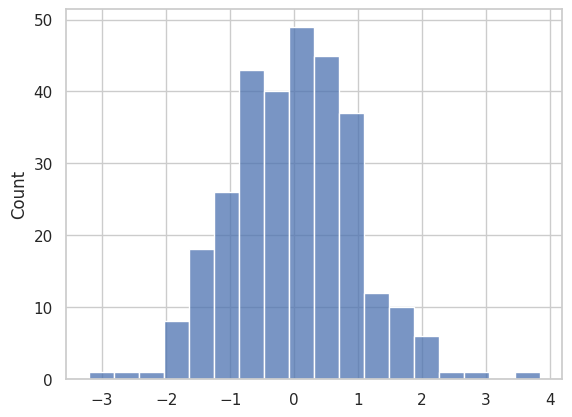

In [47]:
sns.histplot(M[0])

In [48]:
U, S, Vt = np.linalg.svd(M, full_matrices=False)
print(U.shape, S.shape, Vt.shape)
S

(1100, 300) (300,) (300, 300)


array([49.52930877, 49.33874483, 49.04435523, 48.85777223, 48.59780425,
       48.30515054, 48.19762784, 47.74391064, 47.60567271, 47.38248951,
       47.31040164, 47.11333295, 47.05581164, 46.68165859, 46.64153538,
       46.38825538, 46.26812595, 46.17372817, 46.04514253, 45.97483656,
       45.87268864, 45.52702211, 45.46839537, 45.41403153, 45.20645979,
       45.08751567, 44.85957684, 44.80951133, 44.58420962, 44.43933553,
       44.23903519, 44.01973682, 43.98154209, 43.8047093 , 43.72351628,
       43.6650697 , 43.41469849, 43.3676072 , 43.20071775, 43.06050945,
       42.96427738, 42.81398941, 42.70658611, 42.5952928 , 42.49772557,
       42.30831257, 42.1582332 , 42.06899774, 41.85127067, 41.82007078,
       41.6468681 , 41.54589739, 41.45860085, 41.36700383, 41.27945445,
       41.17303134, 41.06842525, 40.83426998, 40.80704864, 40.68091463,
       40.64214108, 40.37243718, 40.35832869, 40.19889136, 40.10231246,
       40.00669827, 39.76371036, 39.70237691, 39.63288849, 39.46

Text(17.31944444444445, 0.5, 'value')

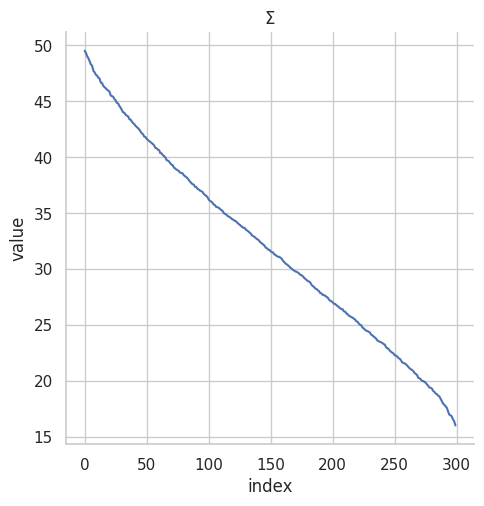

In [49]:
sns.relplot(S, kind="line")
plt.title(r"$\Sigma$")
plt.xlabel("index")
plt.ylabel("value")

Shuffle U, S and V indices to remove singular value order

In [50]:
index_shuffle = list(range(U.shape[1]))
random.shuffle(index_shuffle)
U = U[:, index_shuffle]
S = S[index_shuffle]
Vt = Vt[index_shuffle, :]

Text(17.31944444444445, 0.5, 'value')

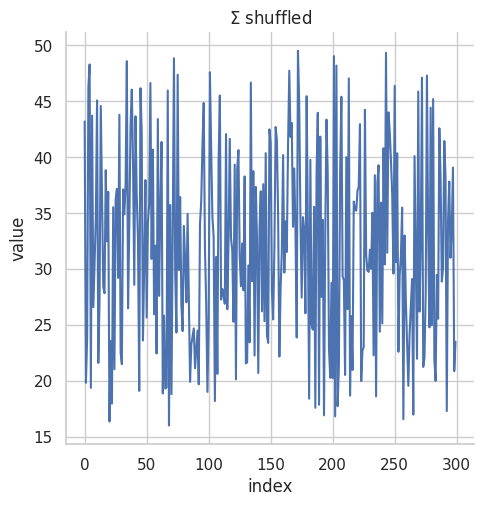

In [51]:
sns.relplot(S, kind="line")
plt.title(r"$\Sigma$ shuffled")
plt.xlabel("index")
plt.ylabel("value")

Split up S to create three orthogonal matrices to be used as feature spaces

In [52]:
start = 0
for rank in d_list:
    _S = np.zeros(len(S))
    _S[start:start + rank] = S[start:start + rank]

    diag_S = np.diag(_S)

    space = U @ diag_S @ Vt
    feature_spaces.append(space)
    start += rank
feature_spaces

[array([[ 0.32645259, -0.44747661, -0.12676704, ..., -0.02062504,
          0.61425703,  0.83999957],
        [-0.34195364,  0.23193241,  0.63742957, ..., -0.23598672,
         -0.05263017,  0.26055956],
        [-0.48602021, -0.70531864, -0.1485145 , ..., -0.94501542,
          1.00297746, -0.45290361],
        ...,
        [ 0.53560068,  0.36390935,  0.67944753, ...,  0.09318046,
          0.2001114 , -0.64197605],
        [ 0.50621563,  0.45196353,  0.0218436 , ...,  1.08422035,
         -0.37095755, -1.14510507],
        [ 0.43693905,  0.07656441, -0.85277143, ..., -0.16953287,
          0.0757938 ,  0.27170284]], shape=(1100, 300)),
 array([[ 2.50592841e-01, -4.32544151e-02, -2.36741734e-01, ...,
          6.10784040e-01, -2.49912559e-02,  6.76375850e-01],
        [-4.43068901e-01, -4.93272735e-01,  4.82810005e-02, ...,
         -3.61544715e-01, -1.20159642e-01,  1.17736723e+00],
        [ 5.31714710e-01,  2.57292834e-01,  7.66831613e-01, ...,
          5.49085471e-01, -4.61523421

Text(0.5, 0, 'value')

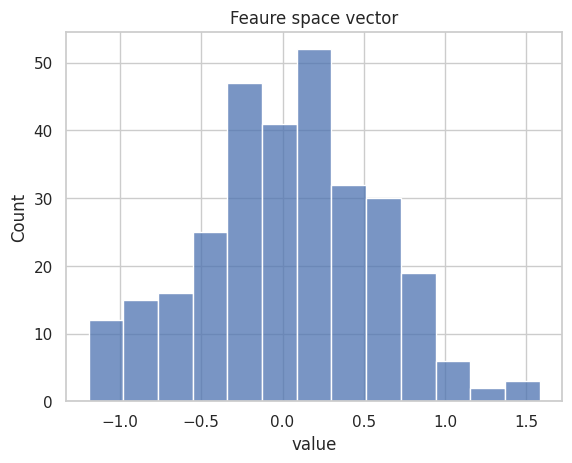

In [53]:
sns.histplot(feature_spaces[0][0])
plt.title("Feaure space vector")
plt.xlabel("value")

make sure that all feature spaces are orthogonal to each other (histograms should be nearly 0)

In [54]:
import pandas as pd

matmuls_df = pd.DataFrame()

for i in range(len(feature_spaces)):
    for j in range(i + 1, len(feature_spaces)):
        first_transposed = feature_spaces[i].T @ feature_spaces[
            j]  # (n_features, n_samples) @ (n_samples, n_features) = (n_
        second_transposed = feature_spaces[i] @ feature_spaces[j].T
        matmuls_df = pd.concat([
            matmuls_df,
            pd.DataFrame(
                {'Features': [f"Space({i}) x Space({j})"], 'Type': ['First Transposed'],
                 'Values (avg across samples)': [first_transposed.mean(axis=0)]}),
            pd.DataFrame(
                {'Type': ['Second Transposed'], 'Values (avg across samples)': [second_transposed.mean(axis=0)],
                 'Features': [f"Space({i}) x Space({j})"]}),
        ], ignore_index=True)
matmuls_df

,Features,Type,Values (avg across samples)
0,Space(0) x Space(1),First Transposed,"[-2.6521319862471414e-16, 2.6178292751125968e-15, -1.8314285273509275e-15, 4.207537096512226e-15, 1.0283849148408815e-15, -1.6676185895144377e-15, 4.3837618720251235e-16, 1.0666814653781387e-16, -1.282573584375039e-15, 1.5163564848208466e-15, 1.5723302289790316e-15, 7.920284798383174e-16, 9.66706460251802e-16, -3.539182835687882e-16, 2.420020202749858e-15, -6.922095998248187e-16, -6.850307358400679e-16, -1.4439606917567478e-15, -4.1311861339229e-15, -2.842390674680691e-15, 4.245446586873906e-17, 3.0051857992837346e-15, -6.1121362600798554e-15, -2.010226476019857e-15, 2.376594291734572e-15, -8.476321496549607e-16, -3.4227713256266648e-15, -1.8466362698236575e-15, -2.089913890094645e-15, -1.2078474794415446e-15, -2.04740160011004e-15, 3.3921361090409146e-15, -1.9849862494443944e-15, -2.548655730905125e-16, 3.0127694320795466e-15, -2.2267662251144554e-15, -3.3090428545416254e-16, -3.358771594186294e-15, 5.961273141785739e-15, 5.095206663992731e-15, 1.1557269898043732e-15, 2.1325880876036742e-15, -1.5794397040247432e-15, 3.39135765188107e-15, 8.87715826773198e-17, 3.404394821604484e-15, 8.201888242650076e-16, -4.861643495187214e-15, 2.4392987629795472e-15, -8.804903420950305e-16, 2.2156697772797903e-15, -9.987843885284064e-16, -4.386884374281882e-15, -2.1335017086343557e-15, 1.5116842962588823e-15, 9.251627242079508e-16, -1.8236656397959315e-15, 5.562240483018381e-15, 2.406493335045205e-15, 3.969284391909985e-15, 2.3191055557407005e-15, -2.647072376108876e-16, -3.594809635150872e-15, -2.5879876945171056e-15, -6.358918021772316e-16, 1.707726841881918e-15, 1.8807178037150153e-15, -1.4190038033490282e-16, 1.5587878210432394e-15, -5.838096210168213e-16, -5.148057905894158e-15, -1.2582296315954978e-15, 2.445702783811695e-15, 2.2583034979077135e-15, -1.1384614316082656e-15, -5.094998497175614e-16, -8.867096871571315e-16, -3.738722294717907e-15, -3.3346936323397357e-15, -1.2624652480826744e-15, 2.479486523506343e-15, -1.458532368954953e-15, -3.595503524541262e-15, -9.781411791642825e-16, -1.0711339222998125e-15, 1.3630734272777426e-15, 1.1691457986925021e-15, 5.062616992290713e-16, 3.282698187353124e-15, -4.018116857758732e-15, 3.429571441652494e-15, -1.5881740367262864e-15, -4.426204773070689e-15, 3.061260735644685e-15, 3.2448580859304835e-15, 1.6618614759785396e-15, 2.9477577786115224e-15, 3.2374103398069565e-15, 3.0860210220584606e-15, 1.524561726862217e-15, ...]"
1,Space(0) x Space(1),Second Transposed,"[-9.173375443099536e-17, -4.7490322123043925e-17, -3.170128301280525e-17, 2.1007107038743684e-17, -1.287834067606716e-16, -1.6308766206194683e-16, 3.2324206442815103e-17, -8.954721434059368e-18, 3.205926685739319e-17, -1.0215944252161596e-17, -3.7366436491709734e-17, -8.473384951392736e-18, 8.117914484568283e-18, -2.9540763774543225e-17, 1.7386463165645273e-16, -1.2483937494867093e-16, -9.520083585093628e-18, 7.478314053868926e-17, 6.32929630423556e-17, -2.6156870230382106e-17, -1.192622389734055e-16, -3.516067645370491e-18, 1.4642187300854436e-16, -2.968584973798856e-17, 1.491341772297261e-16, 1.0014874031082467e-17, -9.454321795140688e-17, -7.006784672671593e-17, 7.537817040371608e-18, 5.785669942663789e-17, -3.5520040191966923e-17, -2.268308646973855e-17, 2.502161199195592e-17, 2.7196829561942662e-17, -2.2221019216592e-17, 6.817778664857212e-17, -2.873687714556216e-17, -1.6529647757880138e-18, 2.5012938374576038e-17, 4.302685890658883e-17, -2.422541334201611e-17, 7.475554266520781e-17, -5.4478621148674645e-17, 6.983365905745907e-17, 1.8765371201379112e-17, 3.090961829922311e-19, -1.7678409241545462e-17, 1.4349218625177927e-16, 7.992915830464091e-17, 9.879782440390773e-17, 1.6312117376546e-17, -7.327708515727303e-17, -7.210072580012625e-17, -5.095355955346422e-18, 7.691921594615343e-17, -1.249607316691139e-16, -7.393588582280877e-17, 4.991903355324532e-17, -7.826047259735186e-17, -1.101681482782648e-16, 2.7371595559859787e-17, 3.810872072452686e-17, 3

In [ ]:
sns.displot(data=matmuls_df.explode("Values (avg across samples)"), x="Values (avg across samples)", multiple="stack",
            col="Type", hue="Features")
plt.suptitle("Feature space matrix multiplications", y=1.02)

split feature spaces into train and test samples

In [33]:
feature_spaces_train = [feature_space[:n_samples_train] for feature_space in feature_spaces]
feature_spaces_test = [feature_space[n_samples_train:] for feature_space in feature_spaces]

add the first feature with all other feature spaces
[0 + 1, 0 + 2, 0 + 3, ...]

In [34]:
Xs_train = [1 / 2 * (feature_spaces_train[0] + feature_space) for feature_space in feature_spaces_train[1:]]
Xs_test = [1 / 2 * (feature_spaces_test[0] + feature_space) for feature_space in feature_spaces_test[1:]]

Xs_train = [zscore(x) for x in Xs_train]
Xs_test = [zscore(x) for x in Xs_test]

generate weights

In [35]:
betas = [np.random.randn(sum(d_list), n_targets) for _ in d_list]
betas = [zscore(beta) for beta in betas]
betas

[array([[-0.38460629, -0.16970626, -0.43662699, ...,  0.76389093,
         -0.54724117,  2.90284843],
        [-0.09814713, -0.20278397,  0.5237513 , ...,  0.93230933,
          1.28752009,  0.04879971],
        [ 0.47496226, -0.72079155, -0.59932401, ..., -0.25245321,
         -0.37423414, -0.61704289],
        ...,
        [ 1.39478625,  0.53454755,  0.11210573, ...,  0.33811356,
          0.07469666,  0.29992802],
        [-0.61751344,  0.74781886,  0.45996191, ...,  2.27891114,
          0.04883194,  0.07789179],
        [-0.98042467, -0.2961056 , -0.67027179, ..., -0.92429298,
          0.47219762,  0.44713567]], shape=(300, 10000)),
 array([[-1.40169847,  2.67279918,  2.03973585, ..., -0.03094923,
         -0.58427223, -0.49388827],
        [-0.66347222,  1.0093984 ,  0.65018904, ..., -0.88144256,
         -1.113028  ,  0.78376731],
        [-1.5680825 , -0.47965058,  1.07959107, ..., -1.27468081,
         -0.45572124,  0.11798338],
        ...,
        [ 1.07480511, -1.37367909,

create targets

In [36]:
Y_train = sum(
    [alpha * zscore(feature_space @ beta) for alpha, feature_space, beta in
     zip(scalars, feature_spaces_train, betas)])
Y_test = sum(
    [alpha * zscore(feature_space @ beta) for alpha, feature_space, beta in
     zip(scalars, feature_spaces_test, betas)])
Y_train = zscore(Y_train)
Y_test = zscore(Y_test)

add noise

In [37]:
noise_train = zscore(np.random.randn(n_samples_train, n_targets))
noise_test = zscore(np.random.randn(n_samples_test, n_targets))
Y_train += noise_train * noise_scalar
Y_test += noise_test * noise_scalar
noise_train * noise_scalar

array([[-0.00063417,  0.01154315, -0.03187855, ...,  0.08611207,
        -0.12916102,  0.08738936],
       [ 0.03938965,  0.00242483, -0.02673386, ...,  0.11971031,
        -0.16322497,  0.09760446],
       [ 0.08482156, -0.09030948,  0.05056161, ..., -0.02505592,
         0.01699247, -0.00441444],
       ...,
       [ 0.15958723,  0.01918551,  0.11944391, ..., -0.06331546,
        -0.02140708,  0.12214556],
       [-0.03527165,  0.07056346, -0.27609341, ...,  0.1827738 ,
         0.00448845, -0.07623852],
       [ 0.19636524,  0.04896127,  0.02460273, ...,  0.02527466,
         0.09929174, -0.21056221]], shape=(1000, 10000))

train simple linear models to confirm feature spaces predict the target

In [38]:
scores = pd.DataFrame()

linear_models = [RidgeCV() for _ in range(len(feature_spaces_train))]
for i, model in enumerate(linear_models):
    model.fit(feature_spaces_train[i], Y_train)
    score = model.score(feature_spaces_test[i], Y_test)
    scores = pd.concat([
        scores,
        pd.DataFrame({'feature space': [i], 'Score': [backend.to_numpy(score).mean()], 'EV': [scalars[i]]})], ignore_index=True
    )
scores

,feature space,Score,EV
0,0,0.177609,0.333333
1,1,0.175178,0.333333
2,2,0.179562,0.333333


Text(0.5, 1.0, 'Hidden feature space scores')

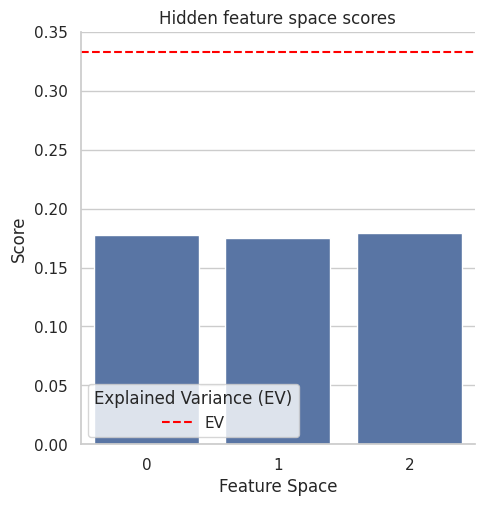

In [39]:
plot = sns.catplot(scores, x="feature space", y="Score", kind="bar").set_axis_labels("Feature Space", "Score")
for index, row in scores.iterrows():
    plot.ax.axhline(row["EV"], color='red', linestyle="--", linewidth=1.5,
                    xmin=index / 3, xmax=(index + 1) / 3,
                    label=f'EV' if index == 0 else None)
plot.ax.legend(title="Explained Variance (EV)")
plt.title("Hidden feature space scores")

now train on researcher side feature spaces

In [41]:
researcher_scores = pd.DataFrame()

linear_models = [RidgeCV() for _ in range(len(Xs_train))]
for i, model in enumerate(linear_models):
    model.fit(Xs_train[i], Y_train)
    score = model.score(Xs_test[i], Y_test)
    researcher_scores = pd.concat([
        researcher_scores,
        pd.DataFrame({'feature space': [i], 'Score': [backend.to_numpy(score).mean()], 'EV': scalars[0] + scalars[i + 1]})],
        ignore_index=True
    )
researcher_scores

,feature space,Score,EV
0,0,0.475214,0.666667
1,1,0.476677,0.666667


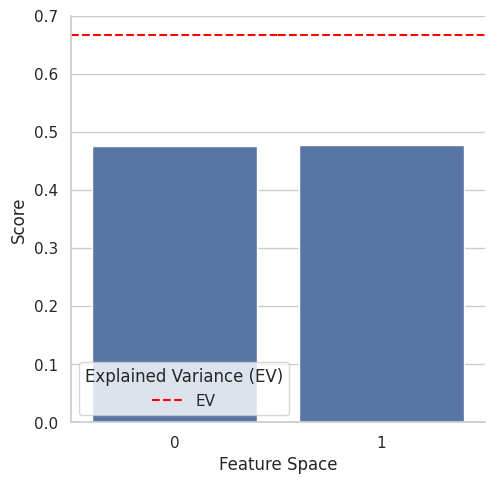

In [42]:
plot = sns.catplot(researcher_scores, x="feature space", y="Score", kind="bar").set_axis_labels("Feature Space", "Score")
for index, row in researcher_scores.iterrows():
    plot.ax.axhline(row["EV"], color='red', linestyle="--", linewidth=1.5,
                    xmin=index / 2, xmax=(index + 1) / 2,
                    label=f'EV' if index == 0 else None)
plot.ax.legend(title="Theoretical EV")
plt.title("Researcher side feature space scores")